In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import load_data
import pathlib


def make_model(base_model, dim_new, channel_axes, img_shape, lr=0.001, batch_size=64,
               initial_epochs=20, tuning_epochs=20, scheduler=True, n_fine_tune=100, 
               save=False, name=None):
    dim_old = 28
    dat_path = pathlib.Path('object_files/').glob('*.npz')
    d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
    print("Start loading dataset")
    train, train_labels, valid, valid_labels, test, test_labels = load_data.load_for_cnn(dat_path, 
                                                                                     dim_old, d, (0.7, 0.25), 
                                                                                     channel_axes=channel_axes, 
                                                                                     dim_new=dim_new)
    print(np.shape(train))
    train_dataset = tf.data.Dataset.from_tensor_slices((train, train_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))
    valid_dataset = tf.data.Dataset.from_tensor_slices((valid, valid_labels))
    train_batches = train_dataset.shuffle(len(train)).batch(batch_size)
    validation_batches = valid_dataset.shuffle(len(valid)).batch(batch_size)

    for image_batch, label_batch in train_batches.take(1):
        pass
    image_batch.shape
    
    base_model.trainable = False
    feature_batch = base_model(image_batch)
    # global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # feature_batch_average = global_average_layer(feature_batch)
    prediction_layer = tf.keras.layers.Dense(7, activation='sigmoid')
    prediction_batch = prediction_layer(feature_batch)
    model = tf.keras.Sequential([
        base_model,
        #global_average_layer,
        prediction_layer
    ])
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=lr),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    print("Compiled Model")

    callbacks = []
    if scheduler:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                                              patience=5, min_lr=1e-5, verbose=1))
    print("Begin Training")
    history = model.fit(train_batches,
                        epochs=initial_epochs,
                        validation_data=validation_batches,
                        callbacks=callbacks)

    base_model.trainable = True

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:n_fine_tune]:
        layer.trainable =  False

    total_epochs =  initial_epochs + tuning_epochs
    print("Begin Fine Tuning")
    history_fine = model.fit(train_batches,
                             epochs=total_epochs,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_batches)
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc += history_fine.history['accuracy']
    val_acc += history_fine.history['val_accuracy']
    loss += history_fine.history['loss']
    val_loss += history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training Loss')
    plt.xlabel('epoch')
    plt.show()

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.title('Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1,initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.title('Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    test_batches = test_dataset.shuffle(len(test)).batch(batch_size)
    loss_test, accuracy_test = model.evaluate(test_batches)
    
    if save:
        model.save('saved_models/' + name) 

Loaded Base Model
Start loading dataset
(49000, 32, 32, 3)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Compiled Model
Begin Training
Epoch 1/20
766/766 [==============================] - 758s 989ms/step - loss: 0.1438 - accuracy: 0.9503 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
766/766 [==============================] - 862s 1s/step - loss: 0.0820 - accuracy: 0.9753 - val_loss: 0.0746 - val_accuracy: 0.9770
Epoch 3/20
766/766 [==============================] - 922s 1s/step - loss: 0.0739 - accuracy: 0.9776 - val_loss: 0.0698 - 

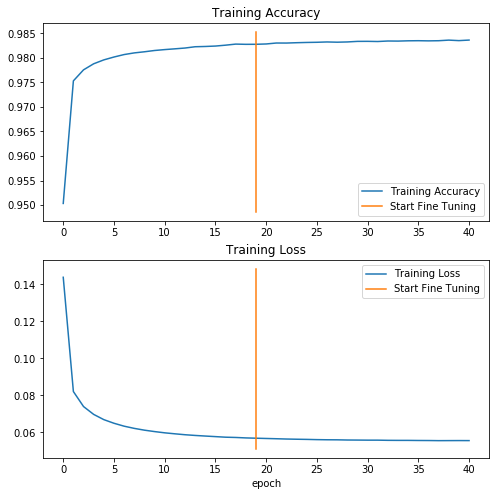

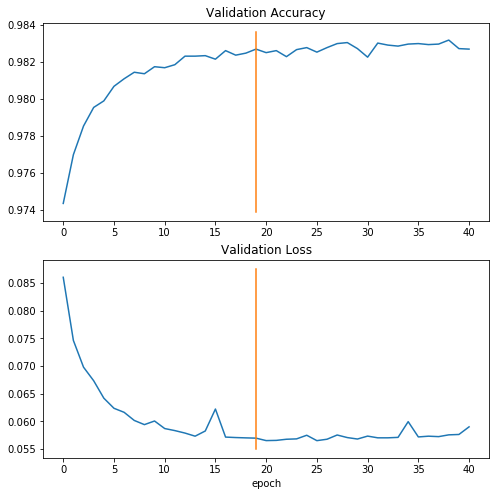

247/247 [==============================] - 191s 772ms/step - loss: 0.0597 - accuracy: 0.9830
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/VGG_model/assets


In [5]:
channel_axes = 3
dim_new = 32
img_shape = (dim_new, dim_new, channel_axes)
base_model = tf.keras.applications.VGG19(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet',
                                         pooling='max')
channel_axes = 3
print("Loaded Base Model")
make_model(base_model, dim_new, channel_axes, img_shape, batch_size=64, initial_epochs=20, tuning_epochs=20, 
           scheduler=True, n_fine_tune=100, save=True, name='VGG_model')


234553344/234545216 [==============================] - 797s 3us/step
Loaded Base Model
Start loading dataset
(49000, 32, 32, 3)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Compiled Model
Begin Training
Epoch 1/20
766/766 [==============================] - 1490s 2s/step - loss: 0.3518 - accuracy: 0.8860 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
766/766 [==============================] - 1350s 2s/step - loss: 0.2838 - accuracy: 0.9064 - val_loss: 0.4080 - val_accuracy: 0.8576
Epoch 3/20
766/766 [==============================] - 

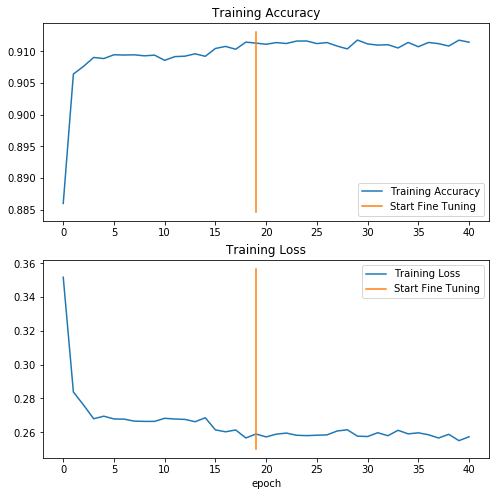

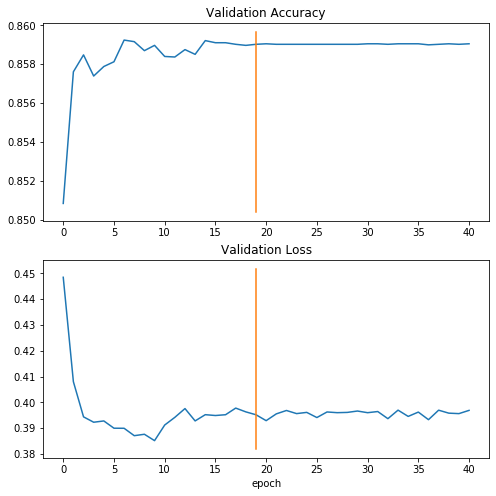

247/247 [==============================] - 156s 632ms/step - loss: 0.3984 - accuracy: 0.8592


In [3]:
channel_axes = 3
dim_new = 32
img_shape = (dim_new, dim_new, channel_axes)
base_model = keras.applications.resnet_v2.ResNet152V2(include_top=False, 
                                                      weights='imagenet', 
                                                      input_shape=img_shape, 
                                                      pooling='max')
channel_axes = 3
print("Loaded Base Model")
make_model(base_model, dim_new, channel_axes, img_shape, batch_size=64,
           initial_epochs=20, tuning_epochs=20, scheduler=True, n_fine_tune=100)